## Task statement
Marketing companies want to run successful campaigns, but the market is complex and several options can work. So normally they tun A/B tests, that is a randomized experimentation process wherein two or more versions of a variable (web page, page element, banner, etc.) are shown to different segments of people at the same time to determine which version leaves the maximum impact and drive business metrics.

The companies are interested in answering two questions:

- Would the campaign be successful?
- If the campaign was successful, how much of that success could be attributed to the ads?

With the second question in mind, we normally do an A/B test. The majority of the people will be exposed to ads (the experimental group). And a small portion of people (the control group) would instead see a Public Service Announcement (PSA) (_or nothing_) in the exact size and place the ad would normally be.

The idea of the dataset is to:
- **analyze the groups**
- **find if the ads were successful**
- **and if the difference between the groups is statistically significant.**

Data dictionary:

- Index: Row index
- user id: User ID (unique)
- test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
- converted: If a person bought the product then True, else is False
- total ads: Amount of ads seen by person
- most ads day: Day that the person saw the biggest amount of ads
- most ads hour: Hour of day that the person saw the biggest amount of ads

In [1]:
# Base
#--------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Hypothesis testing
#--------------------------------
import scipy.stats as stats

# Additional packages
#--------------------------------
from matplotlib.ticker import PercentFormatter

# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('./marketing_AB.csv', index_col=0, header=0, names=['user_id','test_group', 'converted', 'total_ads', 'most_ads_day','most_ads_hour'])

In [3]:
df.dtypes

user_id           int64
test_group       object
converted          bool
total_ads         int64
most_ads_day     object
most_ads_hour     int64
dtype: object

In [4]:
df.sample(10)

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
93414,1063291,ad,False,16,Monday,9
409986,1403907,ad,False,12,Thursday,11
427567,1108014,ad,False,1,Friday,13
3694,1476558,ad,False,175,Wednesday,6
474643,1315478,ad,False,5,Friday,18
180103,1630815,ad,False,41,Sunday,1
391539,1127078,ad,False,16,Saturday,14
272600,1084633,ad,False,4,Wednesday,10
193567,1228339,ad,False,2,Tuesday,9
81794,1126978,ad,True,40,Sunday,21


## EDA

In [5]:
# Number of unique users
print(df.user_id.nunique() == df.shape[0])

True


In [6]:
# Missing values
df.isna().sum()

user_id          0
test_group       0
converted        0
total_ads        0
most_ads_day     0
most_ads_hour    0
dtype: int64

In [7]:
# List unique values in a specific column
df.converted.unique()

array([False,  True])

In [8]:
# Summary Stats: sum_gamerounds
df.describe([0.01, 0.05, 0.1, 0.2, 0.8, 0.9, 0.95, 0.99])[['total_ads', 'most_ads_hour']].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
total_ads,588101.0,24.820876,43.715181,1.0,1.0,1.0,2.0,3.0,13.0,33.0,57.0,88.0,202.0,2065.0
most_ads_hour,588101.0,14.469061,4.834634,0.0,1.0,8.0,9.0,11.0,14.0,19.0,21.0,22.0,23.0,23.0


In [9]:
# A/B groups Summary Stats : total_ads
df.groupby('test_group')['total_ads'].agg(['count', 'median', 'mean', 'std', 'max'])

,count,median,mean,std,max
test_group,,,,,
ad,564577,13.0,24.823365,43.750456,2065
psa,23524,12.0,24.761138,42.860720,907


In [10]:
# A/B groups Summary Stats : most_ads_hour
df.groupby('test_group')['most_ads_hour'].agg(['count', 'median', 'mean', 'std', 'max'])

,count,median,mean,std,max
test_group,,,,,
ad,564577,14.0,14.475900,4.841808,23
psa,23524,14.0,14.304923,4.656239,23


In [11]:
# Conversion distribution within A/B groups
df.groupby(['test_group','converted'])['user_id'].count().unstack()

converted,False,True
test_group,,
ad,550154,14423
psa,23104,420


In [12]:
# Conversion rate within A/B groups
df.groupby('test_group')['converted'].mean()

test_group
ad     0.025547
psa    0.017854
Name: converted, dtype: float64

In [13]:
# Average conversion rate
df.converted.mean()

0.02523886203220195

**Stage summary** <br>
'total_ads' has outliers within each A/B group. <br>
'most_ads_hour' is almost the same within each A/B group. <br>
Difference in conversion is present, but A/B testing will answer whether it is significant. <br>

## Visualizing the data

In [14]:
# User counts
def plot_func(column):
    plt.figure(figsize=(7,5))
    sns.countplot(data=df, x=column, hue=column)
    sns.despine()
    plt.title(f'User Count - {column}')
    plt.show()

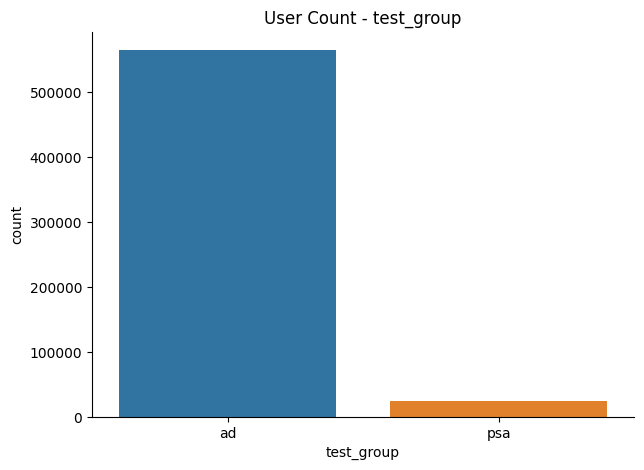

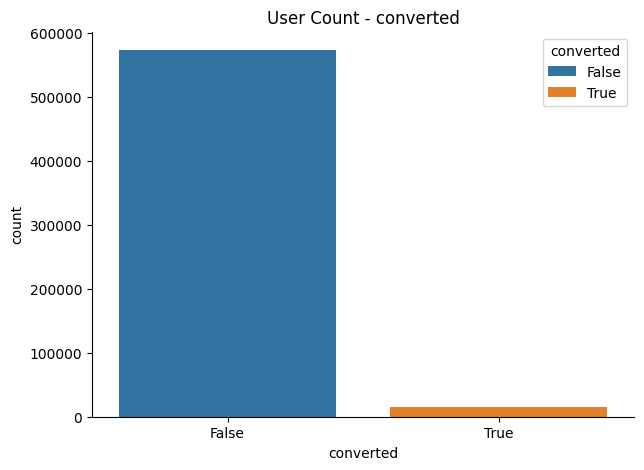

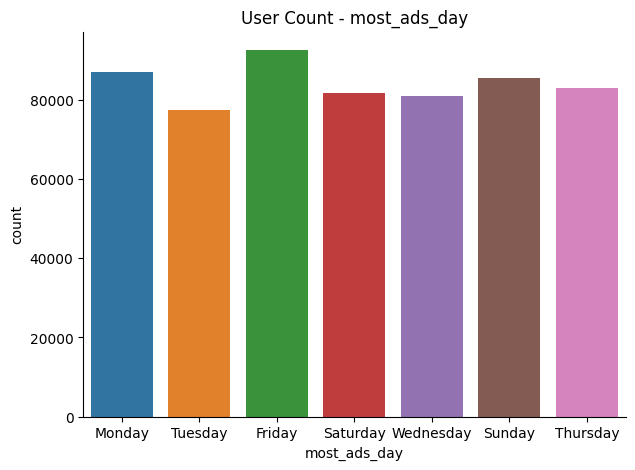

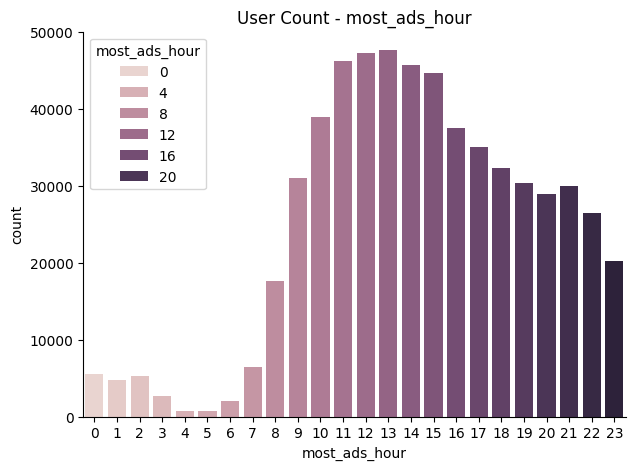

In [15]:
for col in df.columns[[1,2,4,5]]:
    plot_func(col)

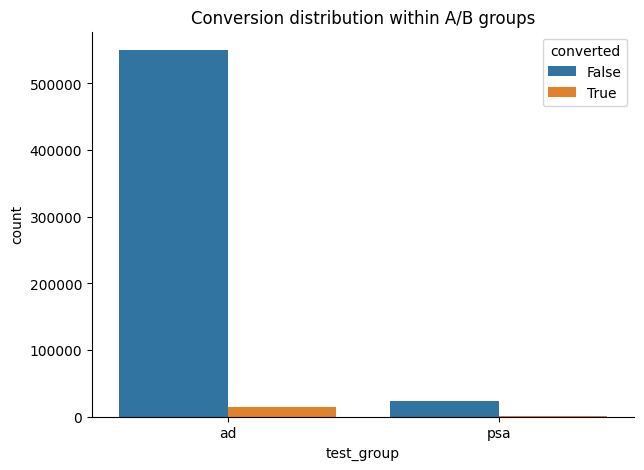

In [16]:
# Visualize conversion distribution for a better grasp
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='test_group', hue='converted')
sns.despine()
plt.title(f'Conversion distribution within A/B groups')
plt.show()

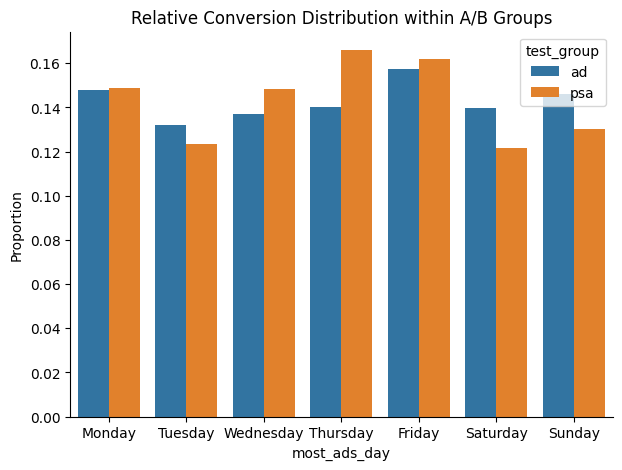

In [17]:
# Conversion Distribution within A/B Groups : most_ads_day
day_order = ['Monday', 'Tuesday','Wednesday','Thursday', 'Friday','Saturday', 'Sunday']

# Calculate the count of each group
group_counts = df.groupby(['test_group', 'most_ads_day']).size().reset_index(name='count')

# Calculate the total number of users in each test group
total_counts = df['test_group'].value_counts().reset_index(name='total_count')

# Merge the total counts with the group counts
group_counts = group_counts.merge(total_counts, on='test_group')

# Calculate the proportion
group_counts['proportion'] = group_counts['count'] / group_counts['total_count']

# Plotting
plt.figure(figsize=(7, 5))
sns.barplot(group_counts, x='most_ads_day', y='proportion', hue='test_group', order=day_order)
sns.despine()
plt.title('Relative Conversion Distribution within A/B Groups')
plt.ylabel('Proportion')
plt.xlabel('most_ads_day')
plt.show()

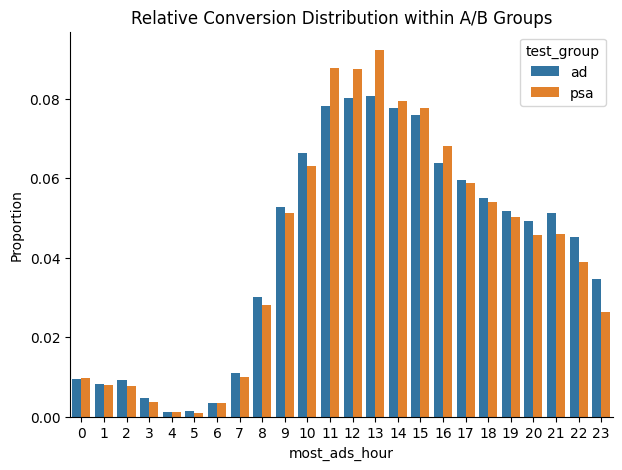

In [18]:
# Conversion Distribution within A/B Groups : most_ads_day
group_counts = df.groupby(['test_group', 'most_ads_hour']).size().reset_index(name='count')
total_counts = df['test_group'].value_counts().reset_index(name='total_count')
group_counts = group_counts.merge(total_counts)
group_counts['proportion'] = group_counts['count'] / group_counts['total_count']

# Plotting
plt.figure(figsize=(7, 5))
sns.barplot(data=group_counts, x='most_ads_hour', y='proportion', hue='test_group')
sns.despine()
plt.title('Relative Conversion Distribution within A/B Groups')
plt.ylabel('Proportion')
plt.xlabel('most_ads_hour')
plt.show()

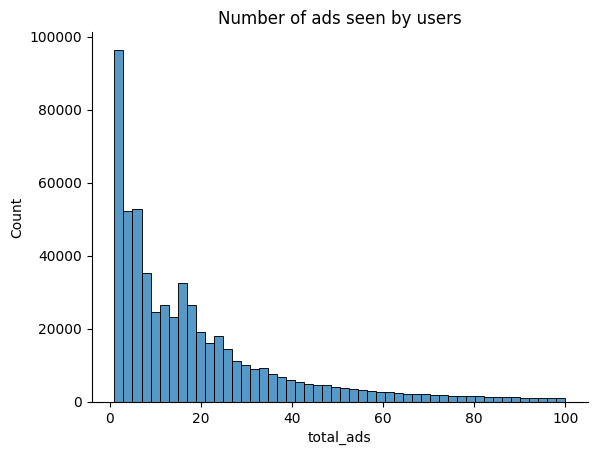

In [19]:
# Count users by ads_seen
sns.histplot(df[(df["total_ads"] > 0) & (df["total_ads"] <= 100)], x='total_ads', bins = 50, edgecolor='black')
sns.despine()
plt.title('Number of ads seen by users')
plt.show()

**Stage summary** <br>
The highest number of ads and psa were seen on Friday and Thursday respectively. <br>
Ads and psa where mostly seen between 10 am and 3 pm. <br>
Most users saw not that many ads, but it would be interesting to see, how their contribution to the conversion looks like by the number of ads seen.

## Removing outliers

In [20]:
# Exclude outliers outside of [Q1 - 1.5*IQR; Q3 + 1.5*IQR] range
# Choosing the upper range as Q3 + 1.5*IQR lead to excluding too many converted user. 
# I made a decision to limit the upper range with .99 quantile instead
Q1 = df.total_ads.quantile(.25)
Q3 = df.total_ads.quantile(.75)
Q99 = df.total_ads.quantile(.99)
IQR = Q3 - Q1
# Q3 + 1.5*IQR

df_1 = df[(df.total_ads >= Q1 - 1.5*IQR) & (df.total_ads <= Q99)]
df_1.sample(5)

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
214789,1375551,ad,False,16,Saturday,20
120671,1415937,ad,False,12,Friday,12
189161,1500593,ad,False,11,Monday,15
376570,1411372,ad,False,1,Tuesday,21
132730,1257985,ad,False,1,Monday,16


In [21]:
df_1.describe([0.01, 0.05, 0.1, 0.2, 0.8, 0.9, 0.95, 0.99])[['total_ads']].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
total_ads,582291.0,21.810997,28.108397,1.0,1.0,1.0,2.0,3.0,13.0,32.0,53.0,79.0,144.0,202.0


In [22]:
df.describe([0.01, 0.05, 0.1, 0.2, 0.8, 0.9, 0.95, 0.99])[['total_ads']].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
total_ads,588101.0,24.820876,43.715181,1.0,1.0,1.0,2.0,3.0,13.0,33.0,57.0,88.0,202.0,2065.0


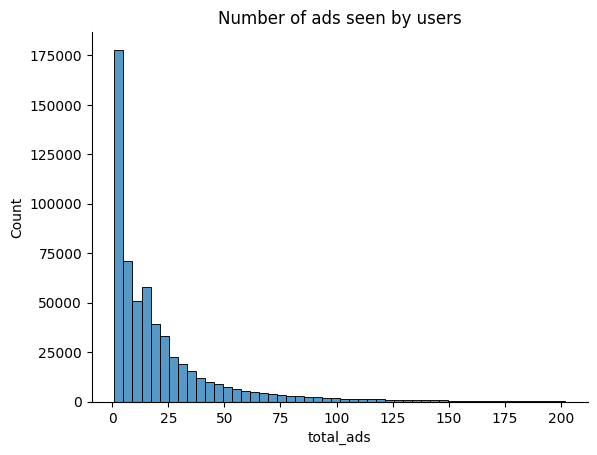

In [23]:
# Count users by ads_seen after removing outliers
sns.histplot(df_1, x='total_ads', edgecolor='black', bins= 50)
sns.despine()
plt.title('Number of ads seen by users')
plt.show()

In [24]:
# See how many converted users are not considered after removing outliers
print(f'Total converted: {df.converted.sum()}')
print(f'Total converted without outliers: {df_1.converted.sum()}')
print(f'By removing {df.shape[0] - df_1.shape[0]} outlier users which represent '
      f'{((df.shape[0] - df_1.shape[0]) / df.shape[0]) * 100:.2f}% of total user base, we take out of consideration '
      f'{df.converted.sum() - df_1.converted.sum()} conversions which accounts for '
      f'{((df.converted.sum() - df_1.converted.sum()) / df.converted.sum()) * 100:.2f}% of total conversions')

Total converted: 14843
Total converted without outliers: 13934
By removing 5810 outlier users which represent 0.99% of total user base, we take out of consideration 909 conversions which accounts for 6.12% of total conversions


### Pareto chart
See contribution to the conversion by the total_ads seen after removing some of the outliers

In [25]:
# Define number of bins
bin_edges = np.linspace(df_1['total_ads'].min(), df_1['total_ads'].max() + 1, num=11).astype(int)

In [26]:
# Bin values into discrete intervals
df_1['bins'] = pd.cut(df_1['total_ads'], bins=bin_edges, include_lowest=True, right=False)

In [27]:
# Create custom labels for better visuals
bin_labels = [f"[{bin_edges[i]}, {bin_edges[i+1]-1}]" for i in range(len(bin_edges)-1)]
df_1['bins'] = df_1['bins'].cat.rename_categories(bin_labels)

In [28]:
# Count the total number of users in bin
group_count = df_1.groupby('bins').size().reset_index(name='count').set_index('bins')
# group_count = df_1.groupby('bins')[['user_id']].count().rename(columns={'user_id':'count'})
group_count

,count
bins,
"[1, 20]",388259
"[21, 40]",107635
"[41, 60]",38822
"[61, 80]",19387
"[81, 101]",11328
"[102, 121]",6441
"[122, 141]",4189
"[142, 161]",2760
"[162, 181]",1983


In [29]:
# Count the number of converted users in bins
converted_in_bin = df_1.groupby('bins')[['converted']].sum()
converted_in_bin

,converted
bins,
"[1, 20]",1928
"[21, 40]",2485
"[41, 60]",2561
"[61, 80]",2281
"[81, 101]",1749
"[102, 121]",1145
"[122, 141]",761
"[142, 161]",468
"[162, 181]",325


In [30]:
# Merge datasets based on bins
df_m = group_count.merge(converted_in_bin, on='bins')

In [31]:
# Sort DataFrame by count descending
df_m = df_m.sort_values(by='count', ascending=False)

# Add column to display cumulative percentage
df_m['cumperc'] = df_m['converted'].cumsum()/df_m['converted'].sum()*100

In [32]:
# df_m['converted'].cumsum().reset_index().set_index('bins')

# (df_m['converted']
# .cumsum()
# .pipe(lambda x: x.reset_index())
# .pipe(lambda x: x.set_index('bins')))

df_m

,count,converted,cumperc
bins,,,
"[1, 20]",388259,1928,13.836659
"[21, 40]",107635,2485,31.670733
"[41, 60]",38822,2561,50.050237
"[61, 80]",19387,2281,66.420267
"[81, 101]",11328,1749,78.972298
"[102, 121]",6441,1145,87.189608
"[122, 141]",4189,761,92.651069
"[142, 161]",2760,468,96.009760
"[162, 181]",1983,325,98.342185


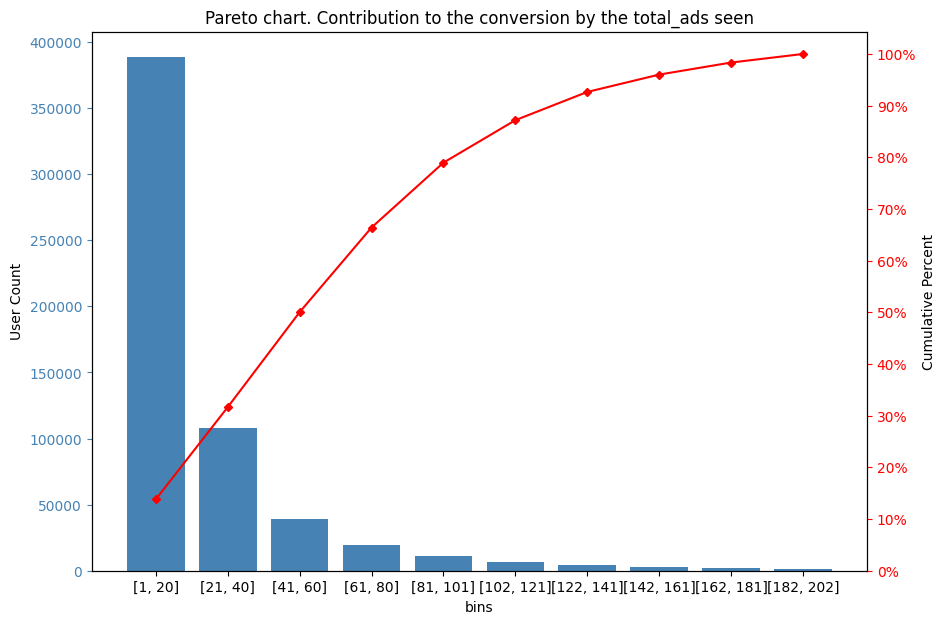

In [33]:
# Define aesthetics for plot
color1 = 'steelblue'
color2 = 'red'
line_size = 4

# Create basic bar plot
fig, ax = plt.subplots(figsize=(10,7))
ax.bar(df_m.index, df_m['count'], color=color1)

# Add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df_m.index, df_m['cumperc'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

# Axis configurations 
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

ax2.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.title('Pareto chart. Contribution to the conversion by the total_ads seen')

ax.set_xlabel('bins')
ax.set_ylabel('User Count')
ax2.set_ylabel('Cumulative Percent')

plt.show()

In [34]:
# Check conversion rate within each bin
df_m['CVR'] = df_m['converted']/df_m['count']*100

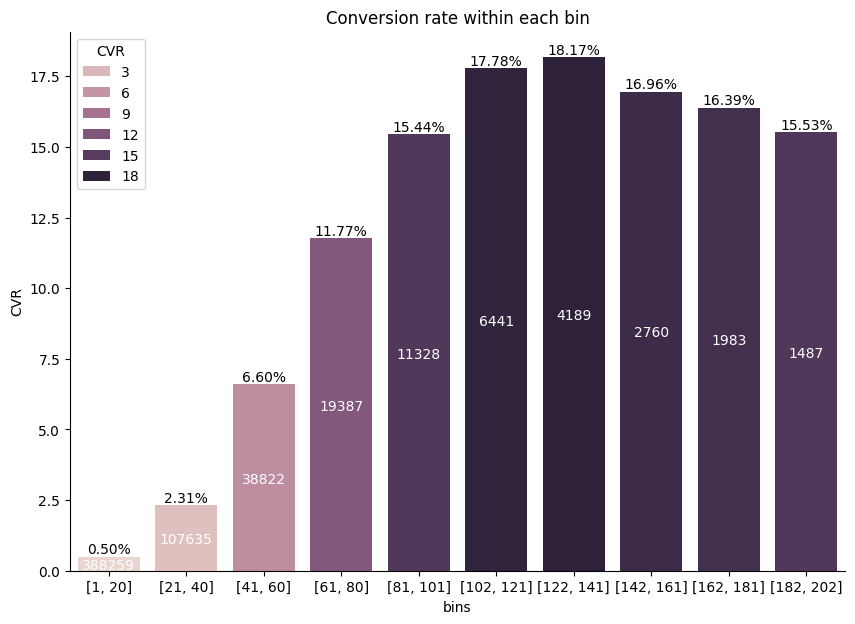

In [35]:
plt.figure(figsize=(10,7))
ax = sns.barplot(data=df_m, x='bins', y='CVR', hue='CVR')
for index, row in df_m.iterrows():
    ax.text(index, row.CVR + 0.1, f"{row.CVR:.2f}%", color='black', ha="center")
    ax.text(index, row.CVR / 2 - 0.2, f"{int(row['count'])}", color='white', ha="center")
# for i in ax.containers:
#     ax.bar_label(i,)
sns.despine()
plt.title('Conversion rate within each bin')
plt.show()
##a3a643

**Stage summary** <br>
With futher EDA was defined the range of data that left after removing the outliers. <br>
I can see that most users haven't seen that many ads. <br> 
Despite a rapid decline in the number of ads viewed, the _contribution_ to the conversion rate remains consistently stable. <br> 
Conversion among those who saw more ads is higher. <br>

**Additional notes**<br> 
Further analysis is hard to conduct due to the lack of additional context. I have no information about the setting of the experiment, conversion alone also is not the best metric.<br>
Thus dataset itself and task statement impose a lot of inherent limitations. <br>
The only meaningful test to run here is chi-square to check significant difference in conversion between the two groups.

In [36]:
treatment = df_1[df_1['test_group'] == 'ad']
control = df_1[df_1['test_group'] == 'psa']

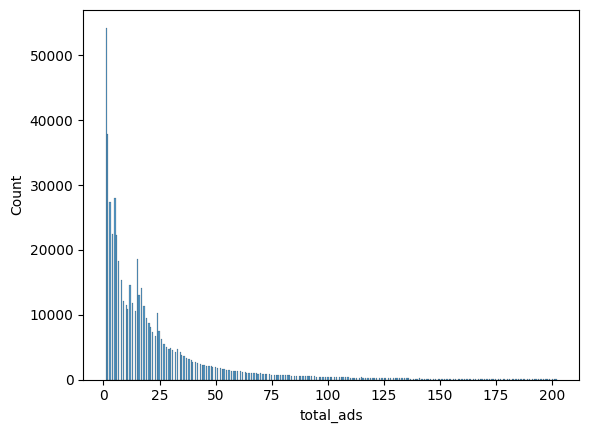

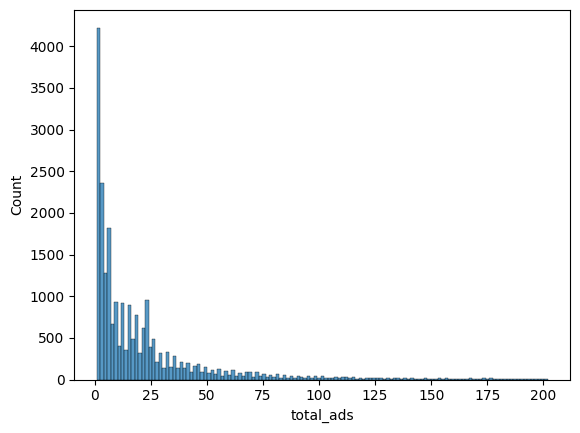

In [37]:
sns.histplot(treatment, x='total_ads')
plt.show()

sns.histplot(control, x='total_ads')
plt.show()

## A/B testing

In [38]:
print('Difference in the conversion between treatment and control: ' f"{((df[df['test_group'] == 'ad'].converted.mean() - df[df['test_group'] == 'psa'].converted.mean())*100)} %")

Difference in the conversion between treatment and control: 0.7692453192201517 %


What is the big question that I need to answer? <br>
Whether this 0.77% difference is meaningful or is it something that occured by chance.

In order to answer this question I can run chi-squre test to tell whether there is a correlation between two categorical variables. <br>
In my case between test_group ('ad', 'psa') and conversion (True, False).

Ho: There is no difference in conversion between groups that saw ads and psa. <br>
Ha: There is a difference.

In [39]:
cross = pd.crosstab(df['test_group'], df['converted'])
cross
# df.groupby(['test_group', 'converted'])['user_id'].count().unstack()

converted,False,True
test_group,,
ad,550154,14423
psa,23104,420


In [40]:
stat, p_val , *_ = stats.chi2_contingency(cross)

In [41]:
def is_significant(p_val, alpha):
    print("p_value: ", p_val)
    if p_val < alpha: 
        print("Reject the null hypothesis")
    else: 
        print("Failed to reject the null hypothesis")

In [42]:
is_significant(p_val, 0.05)

p_value:  1.9989623063390075e-13
Reject the null hypothesis


Thus we conclude that ads were successful. And 0.77% increase in conversion is significant and not based on chance.